## Part I: Preprocessing and EDA

- The data comes from a global e-retailer company, including orders from 2012 to 2015. Import the **Orders** dataset and do some basic EDA. 
- For problem 1 to 3, we mainly focus on data cleaning and data visualizations. You can use all the packages that you are familiar with to conduct some plots and also provide **brief interpretations** about your findings.


In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
plt.style.use('ggplot')

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

### Problem 1: Dataset Import & Cleaning
Check **"Profit"** and **"Sales"** in the dataset, convert these two columns to numeric type. 

In [2]:
df = pd.read_csv('data/Orders.csv', header=0, sep=',', quotechar='"')
df['Profit'] = df['Profit'].str.replace('$', '')
df['Sales'] = df['Sales'].str.replace('$', '')
df['Profit'] = df['Profit'].str.replace(',', '').astype(np.float)
df['Sales'] = df['Sales'].str.replace(',', '').astype(np.float)
#df.dtypes

### Problem 2: Inventory Management
- Retailers that depend on seasonal shoppers have a particularly challenging job when it comes to inventory management. Your manager is making plans for next year's inventory.
- He wants you to answer the following questions:
    1. Is there any seasonal trend of inventory in the company?
    2. Is the seasonal trend the same for different categories?

- ***Hint:*** For each order, it has an attribute called `Quantity` that indicates the number of product in the order. If an order contains more than one product, there will be multiple observations of the same order.

In [3]:
from dateutil.parser import parse

df['order_month'] = [ parse(x).month for x in df["Order.Date"]]
df['order_year'] = [ parse(x).year for x in df["Order.Date"]]
df['order_day'] = [ parse(x).day for x in df["Order.Date"]]
df['order_year_month'] = [ int( parse(x).strftime('%Y%0m') ) for x in df["Order.Date"]]

df['ship_month'] = [ parse(x).month for x in df["Ship.Date"]]
df['ship_year'] = [ parse(x).year for x in df["Ship.Date"]]
df['ship_day'] = [ parse(x).day for x in df["Ship.Date"]]
df['ship_year_month'] = [ int( parse(x).strftime('%Y%0m') ) for x in df["Ship.Date"]]


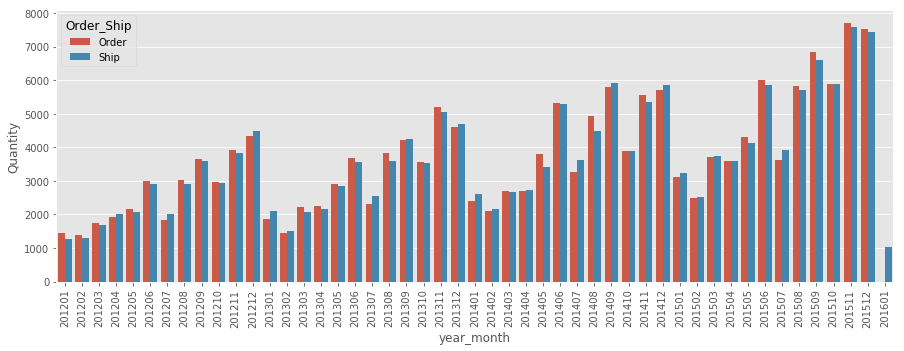

In [4]:
summary_order = df.groupby('order_year_month').agg({'Quantity': 'sum'}).sort_values('order_year_month', ascending=True).reset_index()
summary_ship = df.groupby('ship_year_month').agg({'Quantity': 'sum'}).sort_values('ship_year_month', ascending=True).reset_index()

summary_order.columns = ['year_month', 'Quantity']
summary_order["Order_Ship"] =  ["Order"]*summary_order.shape[0] 

summary_ship.columns = ['year_month', 'Quantity']
summary_ship["Order_Ship"] = ["Ship"]*summary_ship.shape[0] 

mergeData = summary_order.append(summary_ship )
plt.rcParams['figure.figsize'] = 15,5
sns.barplot(x="year_month", y="Quantity", hue= "Order_Ship" ,data=mergeData)
plt.xticks(rotation=90)
plt.show()

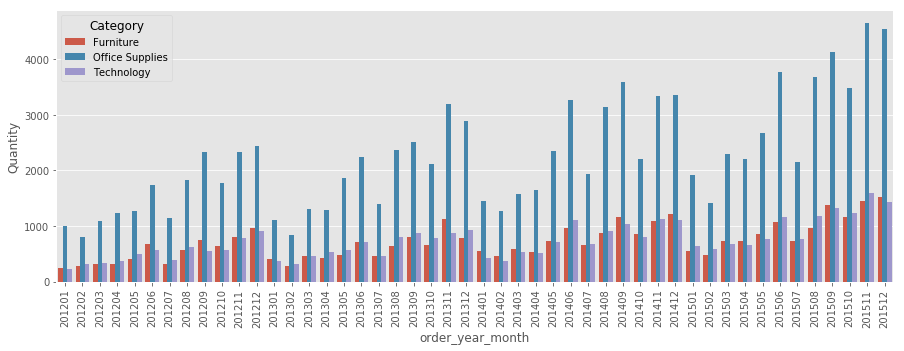

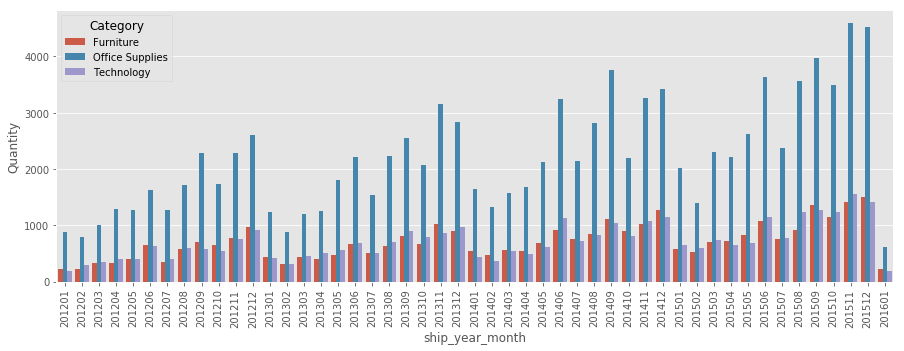

In [5]:
summary_order = df.groupby(['order_year_month', 'Category'] ).agg({'Quantity': 'sum'}).sort_values('order_year_month', ascending=True).reset_index()
summary_ship = df.groupby(['ship_year_month', 'Category']).agg({'Quantity': 'sum'}).sort_values('ship_year_month', ascending=True).reset_index()

sns.barplot(x="order_year_month", y="Quantity", hue= "Category" ,data=summary_order)
plt.xticks(rotation=90)
plt.show()

sns.barplot(x="ship_year_month", y="Quantity", hue= "Category" ,data=summary_ship)
plt.xticks(rotation=90)
plt.show()


### Problem 3: Why did customers make returns?
- Your manager required you to give a brief report (**Plots + Interpretations**) on returned orders.

	1. How much profit did we lose due to returns each year?


	2. How many customer returned more than once? more than 5 times?


	3. Which regions are more likely to return orders?


	4. Which categories (sub-categories) of products are more likely to be returned?

- ***Hint:*** Merge the **Returns** dataframe with the **Orders** dataframe using `Order.ID`.

In [6]:
df_return = pd.read_csv('data/Returns.csv', header=0, sep=',', quotechar='"')
df_return = df_return.set_index("Order ID")

In [7]:
df = df.set_index("Order.ID")

In [8]:
df_combined = pd.merge(df, df_return, left_on = df.index, right_on = df_return.index , how= "outer")

In [9]:
returned = df_combined [ df_combined["Returned"] == "Yes" ]

In [10]:
summary_order = returned.groupby('order_year' ).agg({'Profit': 'sum'}).sort_values('order_year', ascending=True).reset_index()
summary_order

,order_year,Profit
0,2012,17477.26
1,2013,9269.89
2,2014,17510.63
3,2015,17112.97


In [11]:
summary_order = df_combined.groupby('order_year' ).agg({'Profit': 'sum'}).sort_values('order_year', ascending=True).reset_index()
summary_order

,order_year,Profit
0,2012,248940.35
1,2013,307415.33
2,2014,406934.89
3,2015,504166.10


In [12]:
summary_order = returned.groupby('Customer.ID' ).agg({'Returned':'count'}).sort_values('Returned', ascending=False).reset_index()
summary_order[ summary_order["Returned"] > 1 ].shape[0]  #547
summary_order[ summary_order["Returned"] > 5 ].shape[0]  #46

46

In [13]:
summary_order = returned.groupby('Region_y' ).agg({'Returned':'count'}).sort_values('Returned', ascending=False).reset_index()
summary_order.head(1)

,Region_y,Returned
0,Central America,248


In [14]:
summary_order = returned.groupby('Sub.Category' ).agg({'Returned':'count'}).sort_values('Returned', ascending=False).reset_index()
summary_order.head(1)

,Sub.Category,Returned
0,Binders,269


## Part II: Machine Learning and Business Use Case

Now your manager has a basic understanding of why customers returned orders. Next, he wants you to use machine learning to predict which orders are most likely to be returned. In this part, you will generate several features based on our previous findings and your manager's requirements.

### Problem 4: Feature Engineering
#### Step 1: Create the dependent variable
- First of all, we need to generate a categorical variable which indicates whether an order has been returned or not.
- ***Hint:*** the returned orders’ IDs are contained in the dataset “returns”

In [15]:
df_return.index

Index(['CA-2012-SA20830140-41210', 'IN-2012-PB19210127-41259',
       'CA-2012-SC20095140-41174', 'IN-2015-JH158207-42140',
       'IN-2014-LC168857-41747', 'ID-2013-AB1001527-41439',
       'ES-2015-RA1994545-42218', 'CA-2014-TB21280140-41724',
       'ES-2014-JF15295120-41924', 'IN-2014-NM1844527-41800',
       ...
       'IN-2014-SE2011066-41772', 'ES-2015-AS1024064-42297',
       'ZA-2014-LS6945147-41672', 'TU-2014-SF10965134-41992',
       'US-2014-LB16795140-41957', 'IN-2014-DA1345058-41769',
       'US-2013-HG14845140-41530', 'US-2013-SJ2021582-41543',
       'CA-2015-EB13870140-42269', 'EG-2014-PM894038-41846'],
      dtype='object', name='Order ID', length=1079)

#### Step 2:
- Your manager believes that **how long it took the order to ship** would affect whether the customer would return it or not. 
- He wants you to generate a feature which can measure how long it takes the company to process each order.
- ***Hint:*** Process.Time = Ship.Date - Order.Date

In [16]:
from dateutil.parser import parse

df_combined['orderDate'] = [ parse(x) for x in df_combined["Order.Date"]]
df_combined['shipDate'] = [ parse(x) for x in df_combined["Ship.Date"]]
df_combined['Process.Time'] = df_combined['shipDate'] - df_combined['orderDate']

#### Step 3:

- If a product has been returned before, it may be returned again. 
- Let us generate a feature indictes how many times the product has been returned before.
- If it never got returned, we just impute using 0.
- ***Hint:*** Group by different Product.ID

In [17]:
summary_order = df_combined.groupby('Product.ID' ).agg({'Returned':'count'}).sort_values('Returned', ascending=False).reset_index()
summary_order

,Product.ID,Returned
0,OFF-FA-6129,12
1,OFF-ST-6033,9
2,OFF-AR-3499,6
3,OFF-ST-6031,6
4,OFF-ST-6251,6
5,OFF-ST-5693,5
6,OFF-BI-3723,5
7,OFF-AR-3494,5
8,FUR-CH-5378,5
9,OFF-AR-3548,5


### Problem 5: Fitting Models

- You can use any binary classification method you have learned so far.
- Use 80/20 training and test splits to build your model. 
- Double check the column types before you fit the model.
- Only include useful features. i.e all the `ID`s should be excluded from your training set.
- Not that there are only less than 5% of the orders have been returned, so you should consider using the `createDataPartition` function from `caret` package that does a **stratified** random split of the data. Scikit-learn also has a [StratifiedKfold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn-model-selection-stratifiedkfold) function that does similar thing.
- Do forget to `set.seed()` before the spilt to make your result reproducible.
- **Note:** We are not looking for the best tuned model in the lab so don't spend too much time on grid search. Focus on model evaluation and the business use case of each model.


### Problem 6: Evaluating Models
- What is the best metric to evaluate your model. Is accuracy good for this case?
- Now you have multiple models, which one would you pick? 
- Can you get any clue from the confusion matrix? What is the meaning of precision and recall in this case? Which one do you care the most? How will your model help the manager make decisions?
- **Note:** The last question is open-ended. Your answer could be completely different depending on your understanding of this business problem.

### Problem 7: Feature Engineering Revisit
- Is there anything wrong with the new feature we generated? How should we fix it?
- ***Hint***: For the real test set, we do not know it will get returned or not.
